# Epidemic thresholds

Let's look in more detail at the epidemic threshold of the disease. We'll do more simulations focused right in on this region, and see how the *same* parameters generate *different* results within the critical region.

In [1]:
# numpy
import numpy

# data handling
import pandas
from pathlib import Path
datasets = Path("../../datasets")
datasets.mkdir(parents=True, exist_ok=True)

# simulation
from epyc import Experiment, ParallelLab, JSONLabNotebook
from epydemic import ERNetwork, SIR, StochasticDynamics

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

## The simulations

Let's zoom-in on the critical region of our disease outbreaks, but this time run more simulations: specifically, let's look at 10 simulations per $p_{infect}$ value.

In [1]:
# create a lab notebook backed by a JSON file
# (note that the notebook will be loaded, not overwritten, if it exists already)
nb = JSONLabNotebook(Path(datasets, "09-07-sir-threshold.json"), create=True)

NameError: name 'JSONLabNotebook' is not defined

In [3]:
from multiprocessing import cpu_count
print("Current system has {c} cores in total".format(c=cpu_count()))

# pick the number of cores -- change this to change parallelism
nCores = -2

# create the lab
lab = ParallelLab(notebook=nb, cores=nCores)

Current system has 4 cores in total


In [10]:
def sir_er_criticalregion(lab):
    '''Simulate epidemics across the pInfect space.'''

    # set the disease parameter space
    lab[SIR.P_INFECTED] = 0.001
    lab[SIR.P_INFECT] = numpy.linspace(0.0, 0.0002,
                                       num=250)
    lab[SIR.P_REMOVE] = 0.002
    lab['repetitions'] = range(10)   # 10 repetitions at each point

    # set the topology for the generated network
    lab[ERNetwork.N] = int(1e4)
    lab[ERNetwork.KMEAN] = 40

    # create the model, network generator, and experiment
    m = SIR()
    g = ERNetwork()
    e = StochasticDynamics(m, g)
    
    # run the experiment
    lab.runExperiment(e)

In [11]:
lab.createWith("sir_er_criticalregion",
               sir_er_criticalregion,
               "SIR epidemic on ER network, details of the critical region")

True

We can plot this raw data to see more of the structure of the critical region. Each point on the graph corresponds to the final outbreak size of a single simulation.

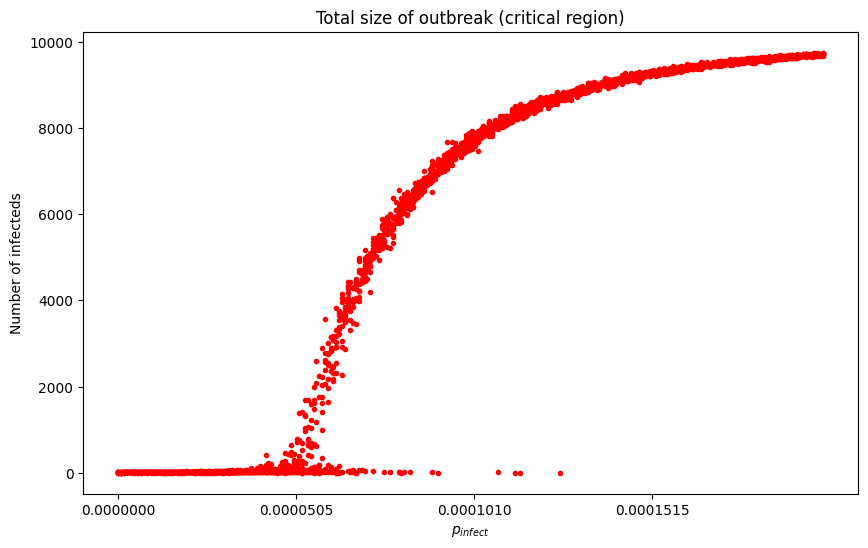

In [15]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sir_er_criticalregion")
ax.plot(df[SIR.P_INFECT], df[SIR.REMOVED], 'r.')

# fill in the title and axis labels
ax.set_title('Total size of outbreak (critical region)')
ax.set_xlabel('$p_{infect}$')
pInfects = numpy.linspace(0.0, 0.0002, num=100)
ax.set_xticks(pInfects[::25])                  # only label some selected points
ax.set_ylabel('Number of infecteds')
plt.show()

Let's go in even closer.

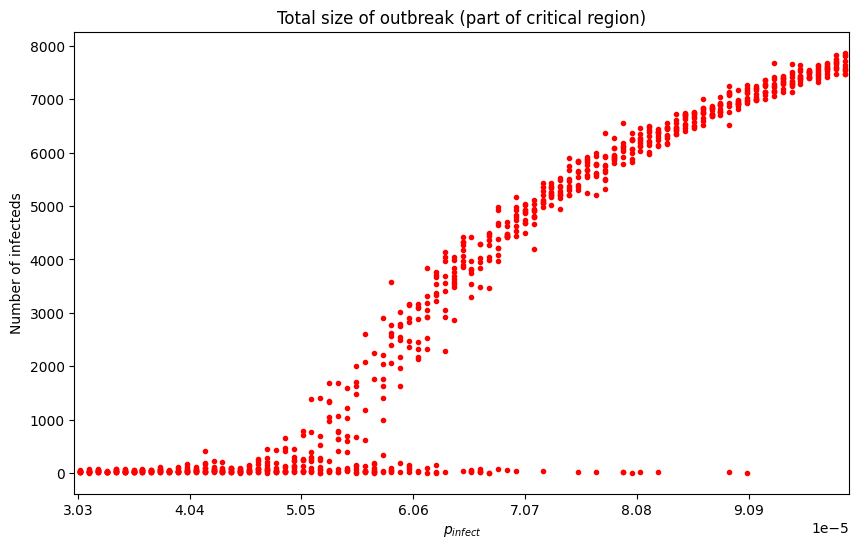

In [22]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()

# plot the sizes of final outbreak size (the R compartment) for different values of pInfect
df = nb.dataframe("sir_er_criticalregion")
df1 = df[df[SIR.P_INFECT] > 0.00003]
df2 = df1[df1[SIR.P_INFECT] < 0.0001]
ax.plot(df2[SIR.P_INFECT], df2[SIR.REMOVED], 'r.')

# fill in the title and axis labels
ax.set_title('Total size of outbreak (part of critical region)')
ax.set_xlabel('$p_{infect}$')
pInfects = numpy.linspace(0.0, 0.0002, num=100)
ax.set_xticks(pInfects[::5])                  # only label some selected points
ax.set_xlim([0.00003, 0.0001])
ax.set_ylabel('Number of infecteds')
plt.show()

We can now see the structure more clearly. At the critical threshold, when the dots begin to leave the x-axis, we can see that the results of individual simulations start to exhibit variance. Just after the threshold we have some simulations with essentially no outbreak, and others covering half the network!

What can we learn from this? Since we know that we have a random network *and* a stochastic process at work, it seems plausible to suggest that minor variations in which nodes are infected, and how they are connected to susceptible nodes, is having a profound effect. If a single infection event doesn't happen, then this can have a significant impact overall: *microscopic* variations are being blown-up to have *macroscopic* effects.